# A/B TESTING WITH MACHINE LEARNING
A/b testing compares the conversion rates of only two groups; Exposed group and the Control group. But in the real world, the situation and even the behaviours of online users is complex and more dynamic. Situations such as:

Online users spend a different amount of time in the Advertisement.
Users take different paths to the Ad.
Users use different devices and Also view the Ad on different dates.

With all these complexity, machine learning helps in generating insights from these complex systems.


### Loading Libraries we will use in the project

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))

In [2]:
# import libraries
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn import preprocessing
from itertools import islice
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import scipy.stats as stat
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
from IPython.display import Image  

from sklearn.tree import export_graphviz
import pydotplus
from sklearn import tree


import warnings
warnings.filterwarnings('ignore')
import dvc.api

### Importing scripts & modules 

In [3]:
from decision import DecisionTreesModel
from logestic import LogesticRegressionModel

from helper import MyHelper
import utility
import plots
Helper = MyHelper()


### Loading the data

In [6]:
CSV_PATH = "../data/AdSmartABdata.csv"
data_frame = Helper.read_csv(CSV_PATH)

>> file read as csv


In [7]:
exp_data=(data_frame.groupby('date')
      .agg(pageviews=('yes','count'),yes=('yes','sum'),no=('no','sum'),hours=('hour','sum'))
      .reset_index()
       )
exp_data

,date,pageviews,yes,no,hours
0,2020-07-03,2015,147,178,27163
1,2020-07-04,903,76,83,9278
2,2020-07-05,890,52,65,9455
3,2020-07-06,490,35,39,2821
4,2020-07-07,480,38,45,5079
5,2020-07-08,1198,85,92,18388
6,2020-07-09,1208,85,99,13729
7,2020-07-10,893,54,70,7902


## K-Fold Cross-validation
Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. 

Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model. 

In this section, we will use it to determine the performance of these models on the BIO data:

- Logistic Regression
- Decision Tree
- XGBoost

### Drop observations where users didn't respond to the questionaire

In [8]:
# drop columns where yes and no are both 0
drop_mask = data_frame.query('yes==0 and no==0') 
data_frame=data_frame.drop(drop_mask.index)
data_frame.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1


### Function for creating an awareness column


In [9]:
def get_data(tag, 
            path='data/AdSmartABdata.csv', 
            repo ='C:/Users/euelf/Desktop/10_AC_CHALLENGES/Week_2/AB_Hypothesis_Testing/abtest-mlops'
):
    rev = tag
    data_url = dvc.api.get_url(path=path, repo=repo, rev=rev)
    df = pd.read_csv(data_url)
    return df

In [10]:
# Function for creating an awareness column
def label_awareness (row):
    if row['yes'] == 1 :
         return '1'
    if row['no'] == 1 :
        return '0'
def calculate_metrics(y_test, y_preds):
    
    accuracy = accuracy_score(y_test, y_preds)
    return accuracy


### Creating 'awarness' column

In [11]:
# apply awareness to each row
data_frame['awareness'] = data_frame.apply (lambda row: label_awareness(row), axis=1) 
data_frame.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no,awareness
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1,0
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0,1
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1,0
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0,1
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1,0


In [12]:
CLEANED_CSV_PATH = "../data/AdSmartABdata.csv"
Helper.save_csv(data_frame, CLEANED_CSV_PATH)

>> File Successfully Saved.!!!


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no,awareness
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1,0
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0,1
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1,0
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0,1
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1,0
...,...,...,...,...,...,...,...,...,...,...
8059,ffa08ff9-a132-4051-aef5-01a9c79367bc,exposed,2020-07-05,21,Generic Smartphone,6,Chrome Mobile,1,0,1
8063,ffb176df-ecd2-45d3-b05f-05b173a093a7,exposed,2020-07-04,1,Generic Smartphone,6,Chrome Mobile,1,0,1
8064,ffb79718-6f25-4896-b6b3-e58b80a6e147,control,2020-07-09,7,Generic Smartphone,6,Chrome Mobile,0,1,0
8069,ffca1153-c182-4f32-9e90-2a6008417497,control,2020-07-10,16,Generic Smartphone,6,Chrome Mobile,0,1,0


### change categorical variables to numerical value


In [13]:
# change categorical variables to numerical value
lb = LabelEncoder()
data_frame['experiment'] = lb.fit_transform(data_frame['experiment'])
data_frame['browser'] = lb.fit_transform(data_frame['browser'])
data_frame['device_make'] = lb.fit_transform(data_frame['device_make'])
data_frame['date'] = lb.fit_transform(data_frame['date'])
data_frame['awareness'] = lb.fit_transform(data_frame['awareness'])


### Split data by browser and platform_os, and version each split as a new version of the data in dvc

In [14]:
broweser_df = data_frame[["experiment", "hour", "date", 'device_make', 'browser', 'awareness']]
platfrom_df = data_frame[["experiment", "hour", "date", 'device_make', 'platform_os', 'awareness']]

### In DVC I saved the 'browser_df' as 'version3' tag

In [15]:
Helper.save_csv(broweser_df, "../data/AdSmartABdata.csv")

>> File Successfully Saved.!!!


,experiment,hour,date,device_make,browser,awareness
2,1,2,2,4,2,0
16,1,16,1,13,1,1
20,1,8,3,13,1,0
23,0,4,5,43,4,1
27,0,15,0,13,1,0
...,...,...,...,...,...,...
8059,1,21,2,13,1,1
8063,1,1,1,13,1,1
8064,0,7,6,13,1,0
8069,0,16,7,13,1,0


### In DVC I saved the 'platform_df' as 'version4' tag

In [16]:
Helper.save_csv(platfrom_df, "../data/AdSmartABdata.csv")

>> File Successfully Saved.!!!


,experiment,hour,date,device_make,platform_os,awareness
2,1,2,2,4,6,0
16,1,16,1,13,6,1
20,1,8,3,13,6,0
23,0,4,5,43,6,1
27,0,15,0,13,6,0
...,...,...,...,...,...,...
8059,1,21,2,13,6,1
8063,1,1,1,13,6,1
8064,0,7,6,13,6,0
8069,0,16,7,13,6,0


## DVC - Different versions of the data tags
### Version 1 - Original Dataset
### Version 2 - 'Awareness' added Dataset 
### Version 3 - Split by 'Browser' Dataset
### Version 4 - Split by 'Platform' Dataset

### Loading the different versions of data into separate dataframe

In [17]:
browser_df = get_data('version3')
platform_df = get_data('version4')

In [18]:
platform_df.head()

,experiment,hour,date,device_make,platform_os,awareness
0,1,2,2,4,6,0
1,1,16,1,13,6,1
2,1,8,3,13,6,0
3,0,4,5,43,6,1
4,0,15,0,13,6,0


In [19]:
browser_df.head()

,experiment,hour,date,device_make,browser,awareness
0,1,2,2,4,2,0
1,1,16,1,13,1,1
2,1,8,3,13,1,0
3,0,4,5,43,4,1
4,0,15,0,13,1,0


## 1 Model training using Decision Tree using browser dataframe


Train Test Split


In [20]:
# feature_cols = ["experiment", "hour", "date", 'device_make', "platform_os",  "browser"]
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['awareness']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Model Training Using DecisionTreesModel

In [21]:
decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

clf, acc_arr, loss_arr = decisionTreesModel.train(5)

step 0: Validation Accuracy of DecisionTreesModel is: 0.571
step 0: Validation Loss of DecisionTreesModel is: 0.655

step 1: Validation Accuracy of DecisionTreesModel is: 0.531
step 1: Validation Loss of DecisionTreesModel is: 0.685

step 2: Validation Accuracy of DecisionTreesModel is: 0.558
step 2: Validation Loss of DecisionTreesModel is: 0.665

step 3: Validation Accuracy of DecisionTreesModel is: 0.516
step 3: Validation Loss of DecisionTreesModel is: 0.696

step 4: Validation Accuracy of DecisionTreesModel is: 0.565
step 4: Validation Loss of DecisionTreesModel is: 0.660



Evaluating our model

step 1: Test Accuracy of DecisionTreesModel is: 0.544
Test Metrics
              precision    recall  f1-score   support

           0       0.95      0.53      0.69       116
           1       0.10      0.67      0.17         9

    accuracy                           0.54       125
   macro avg       0.53      0.60      0.43       125
weighted avg       0.89      0.54      0.65       125

Loss on test data is: 0.675



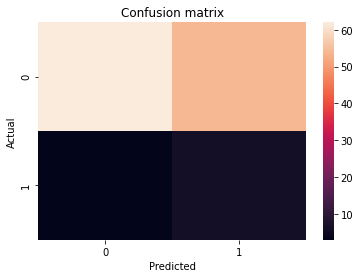

In [22]:
test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()

Calculating feature importance

In [23]:
decisionTreesModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.000000
1,hour,0.401460
2,date,0.054408
3,device_make,0.336032
4,browser,0.208099


## Analysis of the result


__#1 The highest contributing factor for the 'awarness' is 'hour__
Feature importance of hour is 0.41

__#2 The second contributing factor for the 'awarness' is 'device_make__
Feature importance of device_make is 0.33

__#3 The third contributing factor for the 'awarness' is 'browser__
Feature importance of browser is 0.199

__The least contributing factor is 'experiment__
'experiment' feature has 0 factor on Decision Tree Model, which means it is not contributing anything for the awareness. 

## Visualzing feature importance

In [ ]:

dot_data = StringIO()

leaves_parallel=False
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']
out_put_file = "AbTestDecisionTree.dot"

dot_data = export_graphviz(clf, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Aware','Not Aware'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('AbTestDecisionTree.png')

Image(graph.create_png())

### Model training using Decision Tree using 'platform' dataframe


In [24]:
# feature_cols = ["experiment", "hour", "date", 'device_make', "platform_os",  "browser"]
feature_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']

X = platform_df[feature_cols]
y = platform_df[['awareness']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [25]:
decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

clf, acc_arr, loss_arr = decisionTreesModel.train(5)

step 0: Validation Accuracy of DecisionTreesModel is: 0.554
step 0: Validation Loss of DecisionTreesModel is: 0.668

step 1: Validation Accuracy of DecisionTreesModel is: 0.527
step 1: Validation Loss of DecisionTreesModel is: 0.688

step 2: Validation Accuracy of DecisionTreesModel is: 0.554
step 2: Validation Loss of DecisionTreesModel is: 0.668

step 3: Validation Accuracy of DecisionTreesModel is: 0.502
step 3: Validation Loss of DecisionTreesModel is: 0.706

step 4: Validation Accuracy of DecisionTreesModel is: 0.543
step 4: Validation Loss of DecisionTreesModel is: 0.676



step 1: Test Accuracy of DecisionTreesModel is: 0.568
Test Metrics
              precision    recall  f1-score   support

           0       0.95      0.55      0.70       113
           1       0.15      0.75      0.25        12

    accuracy                           0.57       125
   macro avg       0.55      0.65      0.47       125
weighted avg       0.88      0.57      0.65       125

Loss on test data is: 0.657



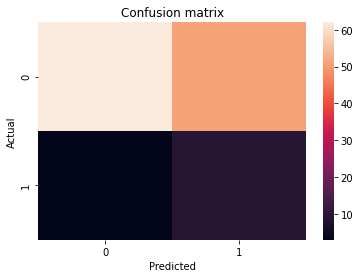

In [26]:
test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()

In [27]:
decisionTreesModel.get_feature_importance()


,feature,feature_importances
0,experiment,0.014389
1,hour,0.453469
2,date,0.176664
3,device_make,0.355477
4,platform_os,0.000000


## Analysis of the result


__#1 The highest contributing factor for the 'awarness' is 'hour__
Feature importance of hour is 0.41

__#2 The second contributing factor for the 'awarness' is 'device_make__
Feature importance of device_make is 0.33

__#3 The third contributing factor for the 'awarness' is 'browser__
Feature importance of browser is 0.199

__The least contributing factor is 'experiment & platform__
'experiment' & 'platform' feature has 0 factor on Decision Tree Model, which means it is not contributing anything for the awareness. 

In [ ]:
dot_data = StringIO()

leaves_parallel=False
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']
out_put_file = "AbTestDecisionTree.dot"

dot_data = export_graphviz(clf, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Aware','Not Aware'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('AbTestDecisionTree.png')

Image(graph.create_png())

Model Building using Logestic Regression

2.1 Model training using Logestic Regression using browser dataframe

In [37]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['awareness']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [38]:
logesticRegressionModel = LogesticRegressionModel(X_train, X_test,  y_train, y_test)

clf2, loss_arr_2, acc_arr_2 = logesticRegressionModel.train(5)

step 0: Validation Accuracy of LogesticRegression is: 0.545
step 0: Validation Loss of LogesticRegression is: 0.675

step 1: Validation Accuracy of LogesticRegression is: 0.527
step 1: Validation Loss of LogesticRegression is: 0.688

step 2: Validation Accuracy of LogesticRegression is: 0.554
step 2: Validation Loss of LogesticRegression is: 0.668

step 3: Validation Accuracy of LogesticRegression is: 0.543
step 3: Validation Loss of LogesticRegression is: 0.676

step 4: Validation Accuracy of LogesticRegression is: 0.574
step 4: Validation Loss of LogesticRegression is: 0.653



step 1: Test Accuracy of LogesticRegression is: 0.552
Test Metrics
              precision    recall  f1-score   support

           0       0.89      0.54      0.67       107
           1       0.18      0.61      0.28        18

    accuracy                           0.55       125
   macro avg       0.54      0.58      0.48       125
weighted avg       0.79      0.55      0.62       125



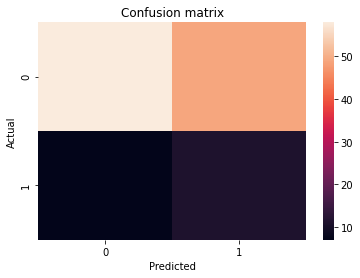

In [39]:
test_acc2, test_loss2, report2, matrix2  = logesticRegressionModel.test()


In [42]:
def get_p_values(df):
    """ 
    Calcualting p_values for logestic regression.
    code refered from the following link
    https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d
    
    """
    denom = (2.0*(1.0+np.cosh(df.clf.decision_function(X))))
    denom = np.tile(denom,(X.shape[1],1)).T
    F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
    Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
    sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
    z_scores = df.clf.coef_[0]/sigma_estimates # z-score 
    p_values = [stat.norm.sf(abs(x)) for x in z_scores] ### two tailed test for p-values
    
    p_df = pd.DataFrame()
    p_df['features'] = df.X_train.columns.to_list()
    p_df['p_values'] = p_values
    
    return p_df
    
def plot_pvalues(self, p_df):
        
    fig, ax = plt.subplots(figsize=(12,7))

    ax.plot([0.05,0.05], [0.05,5])
    sns.scatterplot(data=p_df, y='features', x='p_values', color="green")
    plt.title("P values of features", size=20)

    plt.xticks(np.arange(0,max(p_df['p_values']) + 0.05, 0.05))

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.show()

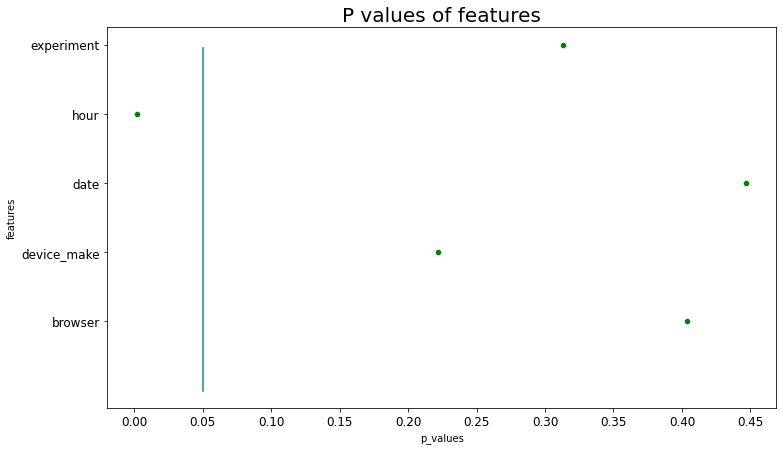

,features,p_values
0,experiment,0.313093
1,hour,0.002316
2,date,0.446756
3,device_make,0.221776
4,browser,0.403688


In [44]:
p_values_df = get_p_values(logesticRegressionModel)
plot_pvalues(logesticRegressionModel,p_values_df)
p_values_df

## Analysis of the result

### TO HAVE SIGINIFICANCE THE P-VALUE MUST BE LESS THAT 0.05

__#1 The highest contributing factor for the 'awarness' is 'hour__
P-value of hour is 0.001

__#2 The second contributing factor for the 'awarness' is 'device_make__
P-value of device_make is 0.221 


__The least contributing factor is 'experiment & browser__
'experiment' & 'platform' feature has no statistical siginficance means it is not contributing anything for the awareness. 


2.2 Model training using Logestic Regression using platfrom dataframe

In [45]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']

X = platform_df[feature_cols]
y = platform_df[['awareness']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [46]:
logesticRegressionModel = LogesticRegressionModel(X_train, X_test,  y_train, y_test)
clf2, loss_arr_2, acc_arr_2 = logesticRegressionModel.train(5)

step 0: Validation Accuracy of LogesticRegression is: 0.518
step 0: Validation Loss of LogesticRegression is: 0.694

step 1: Validation Accuracy of LogesticRegression is: 0.500
step 1: Validation Loss of LogesticRegression is: 0.707

step 2: Validation Accuracy of LogesticRegression is: 0.558
step 2: Validation Loss of LogesticRegression is: 0.665

step 3: Validation Accuracy of LogesticRegression is: 0.534
step 3: Validation Loss of LogesticRegression is: 0.683

step 4: Validation Accuracy of LogesticRegression is: 0.552
step 4: Validation Loss of LogesticRegression is: 0.670



step 1: Test Accuracy of LogesticRegression is: 0.528
Test Metrics
              precision    recall  f1-score   support

           0       0.91      0.53      0.67       112
           1       0.12      0.54      0.19        13

    accuracy                           0.53       125
   macro avg       0.51      0.53      0.43       125
weighted avg       0.83      0.53      0.62       125



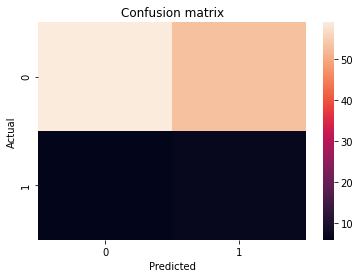

In [47]:
test_acc2, test_loss2, report2, matrix2  = logesticRegressionModel.test()

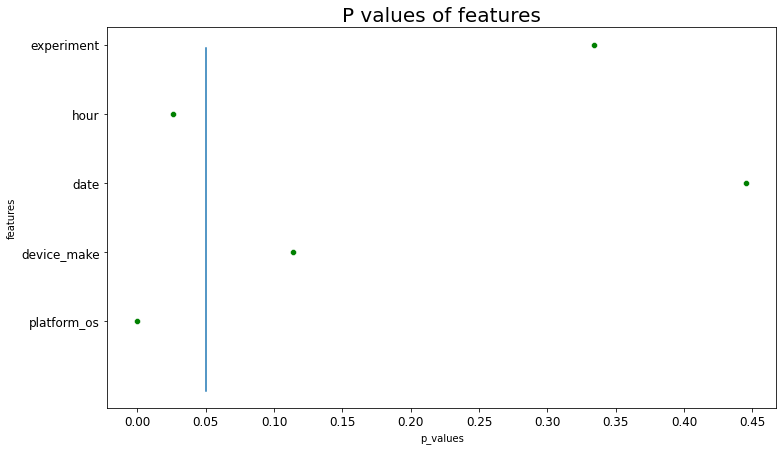

,features,p_values
0,experiment,3.340825e-01
1,hour,2.637949e-02
2,date,4.452749e-01
3,device_make,1.137725e-01
4,platform_os,4.231656e-87


In [48]:
p_values_df = get_p_values(logesticRegressionModel)
plot_pvalues(logesticRegressionModel,p_values_df)
p_values_df

## Analysis of the result

### TO HAVE SIGINIFICANCE THE P-VALUE MUST BE LESS THAT 0.05

__platform and hour have statistical significance__